<a href="https://colab.research.google.com/github/Chandu106/Multiclassification_Food101_project06/blob/main/Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi -L

/bin/bash: nvidia-smi: command not found


## **HELPER FUNCTIONS**

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-21 16:44:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-21 16:44:41 (69.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## **USE TENSORFLOW DATASETS TO DOWNLOAD DATA**

In [5]:
import tensorflow_datasets as tfds

In [6]:
datasets_lists = tfds.list_builders()
print('food101' in datasets_lists)

True


In [7]:
#load the food101 dataset
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True,  #with labels
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteOMW1X7/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteOMW1X7/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# **EXPLORING THE FOOD101 DATA FROM TENSORFLOW DATASETS**

In [8]:
#features of food101 in tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1)


In [11]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101(tensor form):{label}
    Class name (str form): {class_names[label.numpy()]}
    """)



    Image shape: (512, 288, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101(tensor form):93
    Class name (str form): steak
    


In [13]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

#plot an image 

(-0.5, 287.5, 511.5, -0.5)

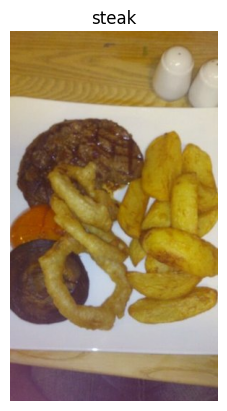

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

# **FUNCTION FOR PREPROCESSING IMAGES**

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]...,
Shape: (512, 288, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[147.30612  102.30612   35.30612 ]
  [147.27551  102.27551   35.27551 ]
  [148.61224  103.61224   36.612244]
  ...
  [145.61224  110.61225   52.612247]
  [145.35715  110.35714   52.357143]
  [145.35715  110.35714   52.357143]]

 [[142.34694   97.34694   30.34694 ]
  [144.85715   99.85714   32.42857 ]
  [146.       101.        33.      ]
  ...
  [144.14285  109.14285   53.142857]
  [144.14285  109.14285   53.142857]
  [143.2857   108.285706  52.28571 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


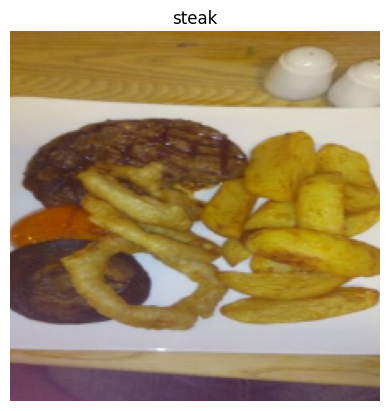

In [17]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# **CREATRING MODEL CALLBACKS**

In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

# **SETUP MIXED PRECISION TRAINING**

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# **BUILDING A FEATURE EXTRACTION MODEL**


In [22]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [24]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype)


input_layer True float32
efficientnetb0 False float32
pooling_layer True float32
dense True float32
softmax_float32 True float32


In [25]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [26]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230421-135404
Epoch 1/3
2368/2368 [==============================] - 209s 80ms/step - loss: 1.7170 - accuracy: 0.5817 - val_loss: 1.1391 - val_accuracy: 0.6962
Epoch 2/3
2368/2368 [==============================] - 192s 80ms/step - loss: 1.1997 - accuracy: 0.6885 - val_loss: 1.0414 - val_accuracy: 0.7177
Epoch 3/3
2368/2368 [==============================] - 178s 74ms/step - loss: 1.0538 - accuracy: 0.7228 - val_loss: 0.9952 - val_accuracy: 0.7230


In [27]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 69ms/step - loss: 0.9960 - accuracy: 0.7293


[0.9960492849349976, 0.7293069362640381]

# **FINETUNE MODEL**

In [29]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [34]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [35]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [36]:
print(len(model.trainable_variables))

12


In [37]:

# Refit the model 
history_finetune = model.fit(train_data,
                            epochs=6,
                            validation_data=test_data,
                            initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # start from previous last epoch
                            validation_steps=int(0.25 * len(test_data)),)
     

Epoch 3/6
2368/2368 [==============================] - 249s 100ms/step - loss: 1.1823 - accuracy: 0.6842 - val_loss: 0.9763 - val_accuracy: 0.7346
Epoch 4/6
2368/2368 [==============================] - 207s 87ms/step - loss: 0.8637 - accuracy: 0.7612 - val_loss: 0.9580 - val_accuracy: 0.7386
Epoch 5/6
2368/2368 [==============================] - 202s 84ms/step - loss: 0.6527 - accuracy: 0.8145 - val_loss: 0.9950 - val_accuracy: 0.7384
Epoch 6/6
2368/2368 [==============================] - 196s 82ms/step - loss: 0.4955 - accuracy: 0.8542 - val_loss: 1.0695 - val_accuracy: 0.7283


In [38]:
model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.0787 - accuracy: 0.7295


[1.0786821842193604, 0.7295049428939819]

In [39]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

258076736/258076736 [==============================] - 9s 0us/step


In [40]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract2 = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230421-145151
Epoch 1/3
2368/2368 [==============================] - 515s 205ms/step - loss: 1.7940 - accuracy: 0.5532 - val_loss: 1.2713 - val_accuracy: 0.6507
Epoch 2/3
2368/2368 [==============================] - 484s 204ms/step - loss: 1.3177 - accuracy: 0.6571 - val_loss: 1.1588 - val_accuracy: 0.6854
Epoch 3/3
2368/2368 [==============================] - 481s 202ms/step - loss: 1.1629 - accuracy: 0.6964 - val_loss: 1.1081 - val_accuracy: 0.7002


In [41]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [42]:
# Refit the model 
history_finetune = model.fit(train_data,
                            epochs=6,
                            validation_data=test_data,
                            initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # start from previous last epoch
                            validation_steps=int(0.25 * len(test_data)),)

Epoch 3/6
2368/2368 [==============================] - 544s 217ms/step - loss: 1.2916 - accuracy: 0.6586 - val_loss: 1.0213 - val_accuracy: 0.7195
Epoch 4/6
2368/2368 [==============================] - 512s 215ms/step - loss: 0.8565 - accuracy: 0.7624 - val_loss: 1.0318 - val_accuracy: 0.7205
Epoch 5/6
2368/2368 [==============================] - 503s 212ms/step - loss: 0.5188 - accuracy: 0.8489 - val_loss: 1.0634 - val_accuracy: 0.7235
Epoch 6/6
2368/2368 [==============================] - 510s 214ms/step - loss: 0.2905 - accuracy: 0.9124 - val_loss: 1.1995 - val_accuracy: 0.7197


In [43]:
model.evaluate(test_data)

790/790 [==============================] - 149s 188ms/step - loss: 1.2247 - accuracy: 0.7174


[1.2246876955032349, 0.7173861265182495]

In [44]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 1s 0us/step


In [48]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract2 = model.fit(train_data, 
                                                     epochs=10,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnet V2B0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet V2B0_101_classes_all_data_feature_extract/20230421-163848
Epoch 1/10
2368/2368 [==============================] - 201s 83ms/step - loss: 0.6493 - accuracy: 0.8291 - val_loss: 0.9928 - val_accuracy: 0.7370
Epoch 2/10


KeyboardInterrupt: ignored

In [47]:
model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 0.9779 - accuracy: 0.7358


[0.977944016456604, 0.7358415722846985]

In [26]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract3 = model.fit(train_data, 
                                                     epochs=10,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnet V2B0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet V2B0_101_classes_all_data_feature_extract/20230421-165914
Epoch 1/10
